# LUS-CS433

TODO general project description + do a readme

For this task, we decide to explore a supervised learning approach, using CNNs.
Our initial idea is the following: to train a binary classifier ideally able to emulate a clinician's judgement, namely telling us wether an image taken from an LUS video of a patient site should be selected or not.

TODO explain why classifier is multi site, wether we should do multiple classifiers (one per site)

### Imports

In [39]:
from encoders import CnnEncoder
from cumulator import base
from plots import plot
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import seaborn as sns
import glob
import sys
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Exploration

TODO some data exploration (number of images, videos, formats, etc)

explain the concept of patient site
#### Image shape
We first check whether images in the dataset have allt the same shapes.

In [2]:
butterfly_img_path = glob.glob("data/Ultrason butterflynetwork/*.png")
lus_neg_img_path = glob.glob("data/ppredictus_images/LUS images/negative/*.png")
vid_img_path = glob.glob("data/Ultrason butterflynetwork/*.mp4")

def count_formats(path_list):
    counts = {}
    for path in path_list:
        key = cv2.imread(path).shape
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts

def count_formats_vid(path_list):
    counts = {}
    for path in path_list:
        video = cv2.VideoCapture(path)
        success, img = video.read()
        
        if success == False :
            raise("Exception nulle")
        
        key = img.shape
        video.release()
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    return counts

In [83]:
butterfly_format = count_formats(butterfly_img_path)
butterfly_format

{(1080, 791, 3): 3445, (1080, 790, 3): 2}

In [84]:
lus_neg_format = count_formats(lus_neg_img_path)
lus_neg_format

{(1080, 804, 3): 1152, (1080, 791, 3): 91}

In [85]:
vid_format = count_formats_vid(vid_img_path)
vid_format

{(1080, 792, 3): 1265}

We see that it is not everywhere the case, so we can't infer that we'll always the same type of images. It seems that our videos have all the same shapes. However most of our images in the butterfly dataset come from videos.

From this analysis, we also get that we have 3447 images in the butterfly dataset, and 1265 videos. While in the LUS_neg dataset, we have 1243 images.

Let's inspect more precisely our videos:

In [5]:
one_vid_path = vid_img_path[0]
print(one_vid_path)
def count_formats_vid(vid_path):
    counts = {}
    video = cv2.VideoCapture(vid_path)
    while(video.isOpened()):
        success, img = video.read()
        
        if success == False :
            print('problem')
            continue
        key = img.shape
        if key not in counts.keys():
            counts[key] = 0
        else:
            counts[key] = counts[key] + 1
    print("hello")
    return counts

data/Ultrason butterflynetwork\1_100_QLD.mp4


In [3]:
#count_formats_vid(one_vid_path)

I couldn't run the cell, but we should have seen that even in one video, the format could sometimes change by one or 2 pixels. This explains why we have different images shape in our images dataset.

#### How is our dataset distributed according to sites?
When a clinician performs a lung ultrasound (LUS) examination, he generally acquires several images on different thoracic sites. Each lung is partitioned in four quadrants (anterior or posterior and superior or inferior). They also perform one lung ultrasound on the side of the lung which implies that a patient could have up to 10 different videos of his lungs.

Here we look how is our data distributed according to each site:

In [7]:
def get_sites(path):
    site_nb = {}
    for data_path in path:
        site_ext = data_path.split('_')[2]#get the site, but could contain extension
        site = site_ext.split(".")[0]#removes the extension
        
        if site not in site_nb.keys():
            site_nb[site] = 1
        else:
            site_nb[site] = site_nb[site] + 1
    return site_nb

In [8]:
#Some files had misspellings, we take fix this here by modifying their names:
old_path = 'data/Ultrason butterflynetwork/1_46_QAiG_1.png'
new_path = old_path.replace("QAiG", "QAIG", 1)
print(new_path)
#os.rename(old_path, new_path)

old_path2 = 'data/Ultrason butterflynetwork/1_156_QASD-1.png'
new_path2 = old_path2.replace("QASD-1", "QASD_1")
print(new_path2)
#os.rename(old_path2, new_path2)

data/Ultrason butterflynetwork/1_46_QAIG_1.png
data/Ultrason butterflynetwork/1_156_QASD_1.png


In [9]:
butterfly_site_nb = dict(sorted(get_sites(butterfly_img_path).items()))
butterfly_site_nb

{'QAID': 367,
 'QAIG': 348,
 'QASD': 397,
 'QASG': 383,
 'QASP': 1,
 'QLD': 229,
 'QLG': 225,
 'QPID': 354,
 'QPIG': 349,
 'QPSD': 397,
 'QPSG': 382,
 'UNK': 17}

We decide that UNK (don't know what it refers to) and QASP (Antérieur Supérieur Postérieur?) images are outliers so we don't consider them

It seems they were already removed


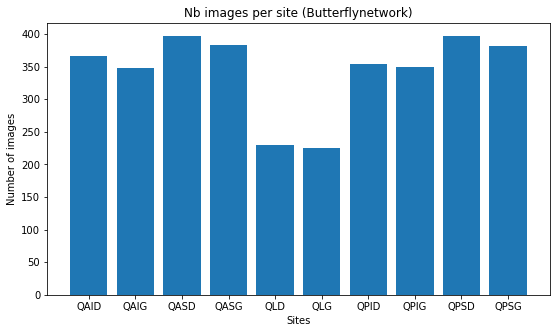

In [27]:
try:
    butterfly_site_nb.pop('UNK')
    butterfly_site_nb.pop('QASP')
except:
    print('It seems they were already removed')

plt.figure(figsize=(9,5))
plt.bar(butterfly_site_nb.keys(), butterfly_site_nb.values())
plt.title('Nb images per site (Butterflynetwork)')
plt.ylabel("Number of images")
plt.xlabel('Sites')
plt.show()

The data is more or less uniformly distributed, we have around 350-400 images per site. There are just the QLD and QLG sites that have around 220 images.

In [28]:
#Same problem here as before:
old_path = 'data/Ultrason butterflynetwork/1_195_QlG.mp4'
new_path = old_path.replace("QlG", "QLG", 1)
print(new_path)
#os.rename(old_path, new_path)

old_path2 = 'data/Ultrason butterflynetwork/1_184_QAiD_1.mp4'
new_path2 = old_path2.replace("QAiD", "QAID")
print(new_path2)
#os.rename(old_path2, new_path2)

data/Ultrason butterflynetwork/1_195_QLG.mp4
data/Ultrason butterflynetwork/1_184_QAID_1.mp4


In [29]:
butterfly_video_site_nb = dict(sorted(get_sites(vid_img_path).items()))
butterfly_video_site_nb

{'QAID': 129,
 'QAIG': 97,
 'QASD': 36,
 'QASG': 47,
 'QLD': 294,
 'QLG': 319,
 'QPAG': 2,
 'QPID': 156,
 'QPIG': 128,
 'QPSD': 34,
 'QPSG': 22,
 'UNK': 2}

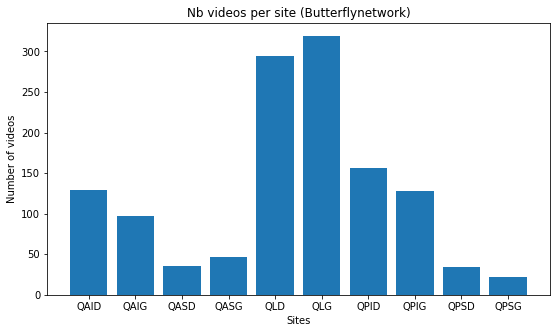

In [30]:
#Same thing here, we remove UNK videos and QPAG videos as their number is to low.
try:
    butterfly_video_site_nb.pop('UNK')
    butterfly_video_site_nb.pop('QPAG')
except:
    print('It seems they were already removed')

plt.figure(figsize=(9,5))
plt.bar(butterfly_video_site_nb.keys(), butterfly_video_site_nb.values())
plt.title('Nb videos per site (Butterflynetwork)')
plt.ylabel("Number of videos")
plt.xlabel('Sites')
plt.show()

Surprisingly, we have a lot more QLD and QLG videos. We know that experts didn't extract an image from every videos or could extract multiple from one. That's why we have this different between the images distribtution and the video distribution

In [21]:
lus_site_nb = get_sites(lus_neg_img_path)
lus_site_nb

{'QAID': 154,
 'QAIG': 113,
 'QASD': 158,
 'QASG': 153,
 'QLD': 89,
 'QLG': 83,
 'QPID': 113,
 'QPIG': 127,
 'QPSD': 129,
 'QPSG': 125,
 'QPG': 1}

It seems they were already removed


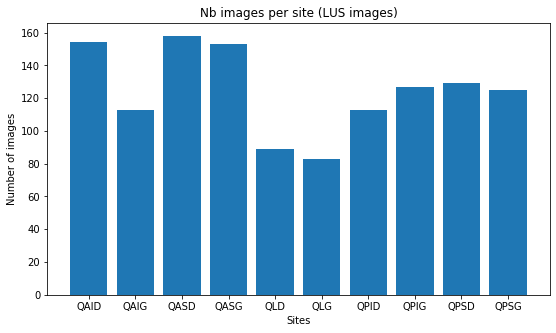

In [23]:
#Remove QPG image
try:
    lus_site_nb.pop('QPG')
except:
    print('It seems they were already removed')
    
plt.figure(figsize=(9,5))
plt.bar(lus_site_nb.keys(), lus_site_nb.values())
plt.title('Nb images per site (LUS images)')
plt.ylabel("Number of images")
plt.xlabel('Sites')
plt.show()

From the other dataset, the same kind of distribution can be observed on the images.

#### How many patients and videos per patient do we have?

In [33]:
def patients_videos(vid_path_list):
    """
    vid_path_list: list of paths of videos
    Returns: Dictionnary with patient number (name) and number of videos associated to him 
    """
    patients = {}
    for path in vid_path_list:
        splitted_path = path.split('_') #split the path
        patient = splitted_path[0][-1] + "_" + splitted_path[1] #extract the patient's number
        if patient not in patients.keys():
            patients[patient] = 1
        else:
            patients[patient] = patients[patient] + 1
    return patients

In [34]:
nb_patients_videos = patients_videos(vid_img_path)

In [35]:
print(f"We have {len(nb_patients_videos.keys())} patients")

We have 193 patients


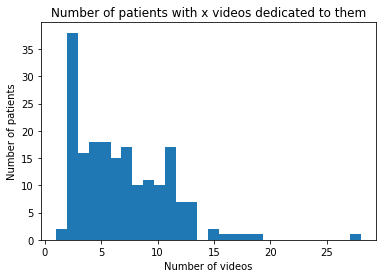

In [58]:
plt.hist(nb_patients_videos.values(), bins = max(nb_patients_videos.values()))
plt.title('Number of patients with x videos dedicated to them')
plt.xlabel('Number of videos')
plt.ylabel('Number of patients')
plt.show()

Seeing this, we want to know how many patients have actually videos from each site:

In [45]:
def sites_per_patient_videos(vid_path_list):
    """
    vid_path_list: list of paths of videos
    Returns: Dictionnary with patient number (name) and all sites that were performed on him
    """
    patients = {}
    for path in vid_path_list:
        splitted_path = path.split('_') #get the patient and the
        patient = splitted_path[0][-1] + "_" + splitted_path[1]
        
        site = splitted_path[2] #get the name of the video
        site = site.split(".")[0] #removes the extension
        
        if patient not in patients.keys():
            patients[patient] = set([site])
        else:
            patients[patient].add(site)
    return patients

In [46]:
sites_per_patient_dic = sites_per_patient_videos(vid_img_path)

In [47]:
nb_sites_per_patient = { k : len(v) for k,v in sites_per_patient_dic.items()}

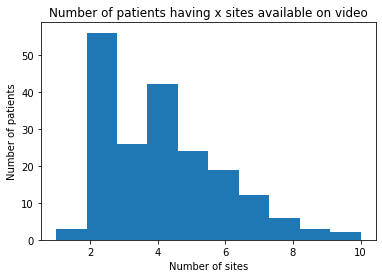

In [57]:
plt.hist(nb_sites_per_patient.values(), bins = max(nb_sites_per_patient.values()))
plt.title('Number of patients having x sites available on video')
plt.xlabel('Number of sites')
plt.ylabel('Number of patients')
plt.show()

Almost every patient does not have one video per site.

## 2. Creating Datasets

In order to train our classifier, we require an image dataset with two different kind of labels:

* "True" images: selected by expert clinicians, these images are known to well represent a patient site and its useful features (such as pleural line, A-lines, B-lines ... etc).
* "False" images: taken from an LUS video, these images were not selected by an expert clinicians thus they do not represent the perfect shot for a given patient site (image can be blurry, features could be missing or angle shot can be weird and thus image is difficult to interpret).

Our initial data contains roughly a thousand expert selected images, which intuitively form our "True" labeled images. However, we do not have any image that would correspond to our "False" label. Therefore we have to generate them ourselves. We use the following methodology to accomplish our goal:

For a given "True" image, we iterate through images from its corresponding video. For each image, we compute a similarity value to the expert image and select the image as a False-labelled one based on this criteria. We require that the expert image and the selected image are not too similar to each other (since it would make the classification too hard), yet they should not be too different either (in order to better simulate the clinician options when selecting the best image). The details of the similarity metric are explained in later sections. 


### 2.1 Creating file folders

First of all, we need to define a function that creates folders that will contain our data. These follow a specific architecture that enables us to use PyTorch Datasets and Dataloaders classes conveniently.

In [2]:
def make_directory(path):
    """
    Create PyTorch compatible folder architecture
    """
    ! mkdir $path
    for kind in ['train/', 'val/']:
        sub_path = path + kind
        ! mkdir $sub_path
        for label in ['true', 'false']:
            full_path = sub_path + label
            ! mkdir $full_path

### 2.2 Image preprocessing

We start by creating a mask that we will use to crop images, getting rid of features on the images (such as the scale, or name of site) that could otherwise perturb the training.
The mask has been crafted manually, as we did not have time to implement automatic edge detrection or similar mechanism to automate the process. We also define a couple functions for common preprocessing operations.

In [3]:
# Main mask used to capture the relevant portion of LUS images. Crafted manually. Is [1,1,1] where image is relevant

# Image dimensions
nb_rows = 1080
nb_cols = 792
nb_channels = 3

mask = np.zeros([nb_rows, nb_cols, nb_channels])

# Filling mask
for row in range(nb_rows):
    for col in range(nb_cols):
        # Delimitations of the cone like portion of a LUS image
        if row > 25 and row < 1010 and col < 762 and (-4/5 * row + 293) < col and (4/5*row) + nb_cols-293 > col:
            mask[row, col] = [1,1,1]

mask = mask.astype('uint8')
            
            
def resize_crop(image, mask, nb_cols=792, nb_rows=1080):
    """
    Resize image and apply mask
    """
    masked_img = cv2.resize(image, (nb_cols, nb_rows))*mask
    return masked_img


def read_crop(image_path, mask, nb_cols=792, nb_rows=1080):
    """
    Read image, resize to given dimensions and apply mask.
    
    Returns: image name, image
    """
    # Reading and masking image
    cv2_img = cv2.imread(image_path)
    masked_img = resize_crop(cv2_img, mask, nb_cols, nb_rows)

    # Selecting image name from path name
    img_name = os.path.split(image_path)[-1]
    
    return img_name, masked_img

### 2.3 Obtaining Test images

Before any dataset generation, we need to select and exclude a few images and video for our testing purposes. We selected five patient ids by hand. These patients present the advantage of having images and corresponding videos for most of the sites.

In [4]:
# TODO rewrite simply
# Create test data folder
! mkdir data/test
! mkdir data/test/test

# Temporary text file used for copying data purposes
! > test_data.txt

# patient ids used for the test set
test_ids = ['.151_','.136_', '.117_', '.45_', '.16_']

files_path = glob.glob("data/Ultrason_butterflynetwork/*")
test_files = [file for file in files_path if any([(id_ in file) for id_ in test_ids])]

file = open("test_data.txt", "w")
for test_file in test_files:
    file.write(test_file+'\n')
file.close()

In [5]:
%%bash
for file in $(cat test_data.txt); 
do
cp $file data/test/test/
done
rm test_data.txt

### 2.2 Obtaining Training and Validation images

We now proceed to dataset generation. First let us define our image similarity mechanism. 

#### 2.2.1 Similarity between two images

The similarity measure was inspired to us by ([Yang et al.](https://arxiv.org/abs/1706.04737), 2017). The idea is to encode a images to lesser dimensional format, reshape them as vector, and finally compute their cosine similarity. The encoding process is necessary to reduce complexity and also avoid potential harm caused by the curse of dimensionality (TODO Prove this). Encoding can be done in various ways. In our project, we selected two methods:
* Computing the mean brightness for a couple subparts of the image, in a convolutional fashion.
* Using a pretrained CNN model (resnet18) stripped from its last layers, as an encoder

The function ```create_brightness_matrix``` implements the first method TODO
Second method TODO

In [4]:
def create_brightness_matrix(img, mask=mask, side_length=200):
    """
    TODO
    """
    img = resize_crop(img, mask)
    # half_side determines the number of pixels per step of the "convolution"
    half_side = int(side_length / 2)
    nb_rows = img.shape[0] // half_side
    nb_cols = img.shape[1] // half_side
    matrix = np.zeros((nb_rows, nb_cols))
    
    for i in range(nb_rows) :
        for j in range(nb_cols) :
            matrix[i, j] = np.mean(img[half_side * i : half_side * i + side_length, half_side * j : half_side * j + side_length]) / 3
    
    return matrix

def cosine_similarity(vector1, vector2):
    """
    Compute the cosine similarity between two vectors of the same size
    """
    return np.dot(vector1,vector2)/(np.linalg.norm(vector1)*np.linalg.norm(vector2))

#### 2.2.1 Generating datasets

Armed with an encoder and a similarity measure, we can now tackle the image selection problem. We will proceed as described in Section 2.

The function ```generate_datasets``` iterates through images present in the given folder, namely the Ultrason butterflynetwork one. For each of these expert selected image, the function tries to find a corresponding (same patient, same site) video through the function ```find_video```. If such video is found, the ```extract_similar_image``` function then iterates through the video, computing the similarity measure between the video's frames and the expert image, in a sequential fashion. If a given frame satisfies the similarity criterias (not too different, not too similar), then both the expert image and the selected frames are saved in their respective folder, namely the True and False labelled ones.

Whenever a frame does not satisfy the similarity criterias, we do not compute similarity for the next couples frames because these are likely to give the same results considering there is very little change between two successive images in a video. This allows us to slightly reduce time complexity.

In [5]:
# TODO hyperparam search on these ?
LAST_SEEN_NB_FRAMES = 40


def generate_dataset(read_path, write_path, encoder, min_similarity, max_similarity, nb_samples=300 , train_ratio=0.8):
    """
    Creates samples for training and validation sets, using an image similarity criteria.
    """
    
    np.random.seed(1)
    images_path = read_path + '.png'
    images_path = np.random.permutation(glob.glob(images_path))
    images_path = [img for img in images_path if not any([(id_ in img) for id_ in test_ids])] # ignore images used for testing
    
    videos_path = read_path + '.mp4'
    videos_path = set(glob.glob(videos_path)) # transformed to set for faster queries
    
    sample_count = 0
    
    # Writing training and validation images to respective folders
    for image_path in images_path:
        # Finding corresponding video
        success, video_path = find_video(image_path, videos_path)
        if success == True:
            if sample_count >= nb_samples:
                break
            else:
                count = extract_similar_image(image_path, video_path, f"{write_path}train/", encoder, min_similarity, max_similarity)
                sample_count += count
    
    # Moving some images to to validation folder
    nb_samples_val = int(sample_count - (sample_count * train_ratio)) # mandatory due to floating point precision
    move_to_val(f"{write_path}train/", f"{write_path}val/", nb_samples_val)
    
    if sample_count < nb_samples:
        print(f"Could not obtain enough samples: \nObtained : {sample_count} \nDemanded: {nb_samples}")
             
            
def move_to_val(img_path, val_path, nb_samples_val):
    """
    Move nb_samples_val images from the img_path folder to the val_path folder
    """
    img_to_move_false = glob.glob(img_path+'false/*')[:nb_samples_val]
    img_to_move_true = glob.glob(img_path+'true/*')[:nb_samples_val]
    val_path_false = val_path + 'false'
    val_path_true = val_path + 'true'
    
    for file_false, file_true in zip(img_to_move_false, img_to_move_true):
        !mv $file_false $val_path_false
        !mv $file_true $val_path_true

        
def extract_similar_image(image_path, video_path, write_path, encoder, min_similarity, max_similarity, mask=mask):
    """
    For a given image, extract a similar sample from the corresponding video (if it exists) and save it.
    """
    # Extracting and encoding the reference expert image
    exp_image = cv2.imread(image_path)
    exp_image_code = encoder(exp_image).reshape(-1)
    
    # Video exploitation
    video = cv2.VideoCapture(video_path)
    last_seen = LAST_SEEN_NB_FRAMES # variable to avoid considering two sample images that are almost the same 
    extraction_success = False
    
    while(video.isOpened()):
        success, sample_image = video.read()
        if (success == True):
            if (last_seen >= LAST_SEEN_NB_FRAMES) :
                # If we have access to an image, we encode it and verify the similarity to the expert image
                sample_image_code = encoder(sample_image).reshape(-1)
                similarity = cosine_similarity(exp_image_code, sample_image_code)
                # If the similarity criterion is satisfied, the image is selected
                if (similarity > min_similarity and similarity < max_similarity):
                    
                    # Saving sampled image
                    _, image_id = os.path.split(image_path)
                    cv2.imwrite(f"{write_path}false/{image_id}", resize_crop(sample_image, mask))
                    
                    # Saving corresponding expert image
                    cv2.imwrite(f"{write_path}true/{image_id}", resize_crop(exp_image, mask))
                    
                    extraction_success = True
                    video.release()
                    break # cv2 does not release video fast enough
                else:
                    last_seen = 0
        else:
            #need to get out the while loop if we can't read a file
            video.release()
        last_seen += 1
    
    return extraction_success

        
def find_video(image_path, videos_path):
    """
    For a given unique image path, find if there is corresponding video in the given list of videos paths
    
    image_path: str, path of single image
    videos_path: set containing paths of all videos
    return: bool, str (operation success, video path)
    """
    video_path = image_path[:-4] + '.mp4'
    if(video_path in videos_path):
        return True, video_path
    else:
        return False, None

Generating the datasets.

In [8]:
similarity_bounds = [[0.8, 0.9], [0.85, 0.95], [0.9, 0.97]]
cnn = CnnEncoder()
cnn = cnn.eval()
encoders = [(create_brightness_matrix, 'brightMat'), (cnn, 'cnn')]
for bounds in similarity_bounds:
    for encoder in encoders:
        dataset_path = f'data/butter_proc_images_{encoder[1]}_{bounds[0]}_{bounds[1]}/'
        make_directory(dataset_path)
        generate_dataset(read_path='data/Ultrason_butterflynetwork/*',
                         write_path=dataset_path,
                         encoder=encoder[0],
                         min_similarity=bounds[0],
                         max_similarity=bounds[1],
                         nb_samples=1000)

Could not obtain enough samples: 
Obtained : 309 
Demanded: 1000
Could not obtain enough samples: 
Obtained : 114 
Demanded: 1000
Could not obtain enough samples: 
Obtained : 509 
Demanded: 1000
Could not obtain enough samples: 
Obtained : 300 
Demanded: 1000
Could not obtain enough samples: 
Obtained : 582 
Demanded: 1000
Could not obtain enough samples: 
Obtained : 449 
Demanded: 1000


## 3. Model training

In [51]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_data(data_path):
    """
    TODO
    """
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                 shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    
    return dataloaders, dataset_sizes, class_names
    
def get_model_and_parameters(model_type):
    """
    TODO
    """
    # Loading pretrained model
    if(model_type is "resnet18"):
        model = models.resnet18(pretrained=True)
    elif(model_type is "googlenet"):
        model = models.googlenet(pretrained=True)
    else:
        raise Error(f"Model {model_type} is not supported")
        
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    
    return model, criterion, optimizer_ft, exp_lr_scheduler

TODO define

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses_tr = []
    losses_val = []
    acc_tr = []
    acc_val = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Storing loss and accuracy values
            if phase == 'train':
                losses_tr.append(epoch_loss)
                acc_tr.append(epoch_acc)
            else:
                losses_val.append(epoch_loss)
                acc_val.append(epoch_acc)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses_tr, losses_val, acc_tr, acc_val

TODO define

In [18]:
! mkdir models
! mkdir models/similarity

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘models/similarity’: File exists


In [59]:
# TODO reduntant with above cell
similarity_bounds = [[0.8, 0.9], [0.85, 0.95], [0.9, 0.97]]
cnn = CnnEncoder()
cnn = cnn.eval()
encoders = [(create_brightness_matrix, 'brightMat'), (cnn, 'cnn')]


model_type = "resnet18"

for bounds in similarity_bounds:
    for encoder in encoders:
        dataset_path = f'data/butter_proc_images_{encoder[1]}_{bounds[0]}_{bounds[1]}/'
        dataloaders, dataset_sizes, class_names = get_data(dataset_path)
        model, criterion, optimizer_ft, exp_lr_scheduler = get_model_and_parameters(model_type)
        
        print(f'\n ########## Encoder ({encoder[1]}) with similarity bounds ({bounds[0]}) and ({bounds[1]}) ##########\n')
        
        # Carbon footprint measurement
        cumulator = base.Cumulator()
        cumulator.on()
        
        # Training model
        model_trained, losses_tr, losses_val, acc_tr, acc_val = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                                    num_epochs=25)
        cumulator.off()
        print(f"Carbon footprint : {cumulator.total_carbon_footprint():.2f} gCO2eq")
        
        # Saving model
        torch.save(model.state_dict(), f"models/similarity/{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}")
        
        # Plotting
        plot(losses_tr, losses_val, 'Training loss', 'Validation loss',
             f'Losses {bounds[0]}_{bounds[1]}', 
             f'figures/losses_{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}.png', 'loss')
        plot(acc_tr, acc_val, 'Training accuracy', 'Validation accuracy',
             f'Accuracy {bounds[0]}_{bounds[1]}',
             f'figures/accuracy_{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}.png', 'accuracy')


 ########## Encoder (brightMat) with similarity bounds (0.8) and (0.9) ##########

Epoch 0/24
----------
train Loss: 0.6218 Acc: 0.6895
val Loss: 3.2029 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.5706 Acc: 0.7641
val Loss: 0.9472 Acc: 0.6230

Epoch 2/24
----------
train Loss: 0.4096 Acc: 0.8206
val Loss: 3.4386 Acc: 0.5000

Epoch 3/24
----------
train Loss: 0.3284 Acc: 0.8810
val Loss: 0.6196 Acc: 0.6885

Epoch 4/24
----------
train Loss: 0.4139 Acc: 0.8548
val Loss: 1.2775 Acc: 0.5656

Epoch 5/24
----------
train Loss: 0.5794 Acc: 0.8044
val Loss: 12.7958 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.2870 Acc: 0.9113
val Loss: 3.1203 Acc: 0.5000

Epoch 7/24
----------
train Loss: 0.2130 Acc: 0.9214
val Loss: 0.0423 Acc: 0.9918

Epoch 8/24
----------
train Loss: 0.1984 Acc: 0.9194
val Loss: 0.0313 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1884 Acc: 0.9315
val Loss: 0.0232 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1428 Acc: 0.9415
val Loss: 0.0988 Acc: 0.9672

E

## 4. Model testing

With our data correctly labeled and organised, we can now proceed to training our model. Training is done in the ```classifier.ipynb``` notebook. In this notebook we directly load our trained models and test them.

### 4.1 Loading the model

In [62]:
def load_model(load_path, device, model_type):
    """
    TODO
    """
    # Loading model architecture
    if(model_type is "resnet18"):
        model = models.resnet18(pretrained=True)
    elif(model_type is "googlenet"):
        model = models.googlenet(pretrained=True)
    else:
        raise Error(f"Model {model_type} is not supported")
        
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)

    # Loading parameters to the model
    model.load_state_dict(torch.load(load_path))
    model = model.to(device)
    model.eval()
    
    return model

### 4.2 Testing

In order to test our model's extraction power we once again use the notion of similarity. For our selected test images, we iterate through the corresponding video running each frame into our model. The one frame that achieves highest confidence as a "True" image is to be selected. We then compute the similarity between our selected image and the expert one. This measure is our testing metric. The higher, the closer our model as been able to emulate the expert's decision. 

In [61]:
def prepare_for_model(img):
    """
    Read image and apply required transformations for model usage
    """
    # Read, resize and crop
    img = resize_crop(img, mask)
    
    # Transform to PIL format
    img = Image.fromarray(img)
    
    # Images transformations to apply before entering model
    transform = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    return transform(img)


def test_model(model, test_folder_path, encoder):
    """
    Test the given model on images and videos contained in the given folder, based on a similarity metric
    Return the average similarity between expert images and model selectd images from the corresponding videos
    """
    images_path = test_folder_path + 'test/*.png'
    images_path = glob.glob(images_path)
    
    videos_path = test_folder_path + 'test/*.mp4'
    videos_path = set(glob.glob(videos_path)) # transformed to set for faster queries
    
    similarities = []
    
    # Use model on image every 'skip' frames
    skip = 10
    # TODO debug stuff
    #images_path = images_path[:3]
    #print(images_path)
    
    for image_path in images_path:
        # Finding corresponding video
        success, video_path = find_video(image_path, videos_path)
        if(success == True):
            # Scanning the video
            video = cv2.VideoCapture(video_path)
            frame = 0
            best_confidence = 0
            selected_image = None
            while(video.isOpened()):
                success, sample_image = video.read()
                if(success == True):
                    frame += 1
                    if(frame % skip == 0):
                        # Sampled image goes through the model
                        model_image = prepare_for_model(sample_image)
                        model_image = torch.unsqueeze(model_image, 0) # adding dummy batch dimension
                        model_image = model_image.to(device)
                        probabilities = nn.functional.softmax(model(model_image), dim = 1)
                        confidence = probabilities[0,1]

                        if(confidence >= best_confidence):
                            best_confidence = confidence
                            selected_image = sample_image.copy()
                else:
                    video.release()
            
            # Computing similarity
            if selected_image is not None:
                exp_image = cv2.imread(image_path)
                exp_image_code = encoder(exp_image).reshape(-1)
                selected_image_code = encoder(selected_image).reshape(-1)
                similarity = cosine_similarity(exp_image_code, selected_image_code)
                similarities.append(similarity)
    
    # Averaging similarity TODO think of another method ?
    return np.mean(similarities)

Computing average similarity over the test set:

In [71]:
model_type = "resnet18"
test_folder_path = "data/test/"

for bounds in similarity_bounds:
    for test_encoder in encoders:
        for encoder in encoders:
            # Loading model
            model_path = f'models/similarity/{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}'
            model = load_model(model_path, device, model_type)
            print(f'\n ########## Model trained with encoder ({encoder[1]}) and similarity bounds ({bounds[0]}) - ({bounds[1]}), test similarity through {test_encoder[1]} ##########\n')

            # Testing
            mean_similarity = test_model(model, test_folder_path, test_encoder[0])
            print(f'Mean similarity on test set: {mean_similarity:.4f}')


 ########## Model trained with encoder (brightMat) and similarity bounds (0.8) - (0.9), test similarity through brightMat ##########

Mean similarity on test set: 0.9447

 ########## Model trained with encoder (cnn) and similarity bounds (0.8) - (0.9), test similarity through brightMat ##########

Mean similarity on test set: 0.9441

 ########## Model trained with encoder (brightMat) and similarity bounds (0.8) - (0.9), test similarity through cnn ##########

Mean similarity on test set: 0.9641

 ########## Model trained with encoder (cnn) and similarity bounds (0.8) - (0.9), test similarity through cnn ##########

Mean similarity on test set: 0.9652

 ########## Model trained with encoder (brightMat) and similarity bounds (0.85) - (0.95), test similarity through brightMat ##########

Mean similarity on test set: 0.9413

 ########## Model trained with encoder (cnn) and similarity bounds (0.85) - (0.95), test similarity through brightMat ##########

Mean similarity on test set: 0.9463


In [114]:
def generate_confident_images(model, test_folder_path, write_path):
    """
    TODO
    """   
    videos_path = test_folder_path + 'test/*.mp4'
    videos_path = glob.glob(videos_path)
    
    good_counter = 0
    avg_counter = 0
    bad_counter = 0
    
    # Use model on image every 'skip' frames
    skip = 3
    # TODO debug stuff
    #images_path = images_path[:3]
    #print(images_path)
    
    for video_path in videos_path:
        # Scanning the video
        video = cv2.VideoCapture(video_path)
        frame = 0
        best_confidence = 0
        min_best_confidence = 0.7
        selected_image = None
        average_image = None
        bad_image = None
        while(video.isOpened()):
            success, sample_image = video.read()
            if(success == True):
                frame += 1
                if(frame % skip == 0):
                    # Sampled image goes through the model
                    model_image = prepare_for_model(sample_image)
                    model_image = torch.unsqueeze(model_image, 0) # adding dummy batch dimension
                    model_image = model_image.to(device)
                    probabilities = nn.functional.softmax(model(model_image), dim = 1)
                    confidence = probabilities[0,1]
                    if((confidence >= min_best_confidence) and (confidence >= best_confidence)):
                        best_confidence = confidence
                        selected_image = sample_image.copy()
                    
                    if((average_image is None) and ((confidence < 0.7) and (confidence > 0.2))):
                        average_image = sample_image.copy()
                        
                    if((bad_image is None) and (confidence < 0.2)):
                        bad_image = sample_image.copy()                         
            else:
                video.release()

        # Writing images
        image_id = os.path.split(video_path)[-1][:-4] + '.png'
        if selected_image is not None:
            good_counter +=1
            #cv2.imwrite(f"{write_path}best/{image_id}", resize_crop(selected_image, mask))
        
        if average_image is not None:
            avg_counter +=1
            #cv2.imwrite(f"{write_path}average/{image_id}", resize_crop(average_image, mask))
        
        if bad_image is not None:
            bad_counter +=1
            #cv2.imwrite(f"{write_path}bad/{image_id}", resize_crop(bad_image, mask))
            
    print("Good", good_counter)
    print("Ugly", avg_counter)
    print("Bad", bad_counter)

In [115]:
for bounds in similarity_bounds:
    for encoder in encoders:
        # Loading model
        model_path = f'models/similarity/{model_type}_natural_{encoder[1]}_{bounds[0]}_{bounds[1]}'
        model = load_model(model_path, device, model_type)
        print(f'\n ########## Model trained with encoder ({encoder[1]}) and similarity bounds ({bounds[0]}) - ({bounds[1]}) ##########\n')
        generate_confident_images(model, test_folder_path, 'data/selected_images/')


 ########## Model trained with encoder (brightMat) and similarity bounds (0.8) - (0.9) ##########

Good 1
Ugly 24
Bad 74

 ########## Model trained with encoder (cnn) and similarity bounds (0.8) - (0.9) ##########

Good 13
Ugly 32
Bad 72

 ########## Model trained with encoder (brightMat) and similarity bounds (0.85) - (0.95) ##########

Good 0
Ugly 2
Bad 74

 ########## Model trained with encoder (cnn) and similarity bounds (0.85) - (0.95) ##########

Good 2
Ugly 23
Bad 74

 ########## Model trained with encoder (brightMat) and similarity bounds (0.9) - (0.97) ##########

Good 0
Ugly 4
Bad 74

 ########## Model trained with encoder (cnn) and similarity bounds (0.9) - (0.97) ##########

Good 0
Ugly 1
Bad 74


In [98]:
def give_confidence_test_set_images(model, test_folder_path):
    """
    TODO
    """   
    images_path = test_folder_path + 'test/*.png'
    images_path = glob.glob(images_path)
    
    
    # Use model on image every 'skip' frames
    skip = 10
    # TODO debug stuff
    #images_path = images_path[:3]
    #print(images_path)
    
    good_counter = 0
    avg_counter = 0
    bad_counter = 0
    
    for image_path in images_path:
        sample_image = cv2.imread(image_path)
        # Sampled image goes through the model
        model_image = prepare_for_model(sample_image)
        model_image = torch.unsqueeze(model_image, 0) # adding dummy batch dimension
        model_image = model_image.to(device)
        probabilities = nn.functional.softmax(model(model_image), dim = 1)
        confidence = probabilities[0,1]
        
        if confidence > 0.7:
            good_counter += 1
        elif confidence < 0.2:
            bad_counter +=1
        else:
            avg_counter += 1
            
    print("Good", good_counter)
    print("Ugly", avg_counter)
    print("Bad", bad_counter)

In [99]:
give_confidence_test_set_images(model, test_folder_path)

Good 74
Ugly 0
Bad 0
